In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import os
from sklearn.metrics import f1_score

from fastai import *
from fastai.vision import *

import torch
import torch.nn as nn
import torchvision
import cv2
import random

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload

In [3]:
!mkdir train  #create a directory named train/
!mkdir test  #create a directory named test/

!unzip "/content/drive/My Drive/Pcam/train_labels.csv.zip" 
!unzip "/content/drive/My Drive/Pcam/sample_submission.csv.zip"

!unzip -q "/content/drive/My Drive/Pcam/test.zip" -d test/

Archive:  /content/drive/My Drive/Pcam/train_labels.csv.zip
  inflating: train_labels.csv        
Archive:  /content/drive/My Drive/Pcam/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
!unzip -q "/content/drive/My Drive/Pcam/train.zip" -d train/

In [3]:
model_path='.'

path='../content/'
train_lbl = '/content/train_labels.csv'
train_folder = '/content/train/'
test_folder = '/content/test/test/'


print(f'{len(os.listdir(train_folder))} pictures in train.')
print(f'{len(os.listdir(test_folder))} pictures in test.')

bs=64
num_workers=None # Apprently 2 cpus per kaggle node, so 4 threads I think
sz=96

220025 pictures in train.
57459 pictures in test.


In [0]:
df_trn=pd.read_csv(train_lbl)

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

In [6]:
data = ImageDataBunch.from_csv(path,csv_labels=train_lbl,folder='train', ds_tfms=tfms, size=sz, suffix='.tif',test=test_folder,bs=bs);
stats=data.batch_stats()        
data.normalize(stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,1,1
Path: ../content;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,1,0,1,0
Path: ../content;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: ../content

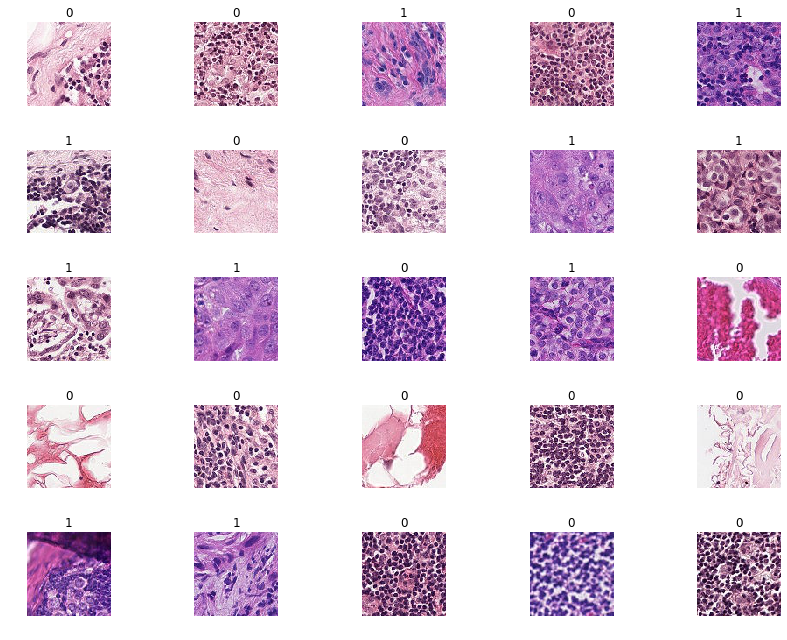

In [17]:
data.show_batch(rows=5, figsize=(12,9))

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [0]:
from torchvision.models import *

In [0]:
learn = create_cnn(
    data,
    densenet121,
    path='.',    
    metrics=[auc_score],
    ps=0.5
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


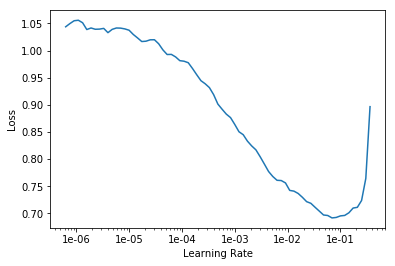

In [13]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,auc_score,time
0,0.213866,0.207288,0.970495,15:26


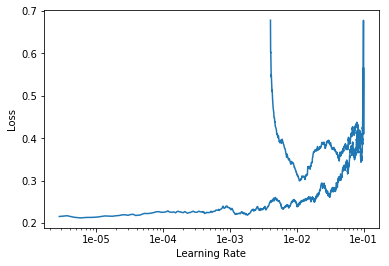

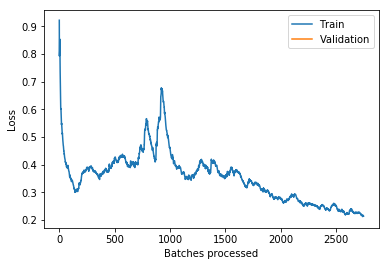

In [14]:
learn.fit_one_cycle(1,1e-01)
learn.recorder.plot()
learn.recorder.plot_losses()


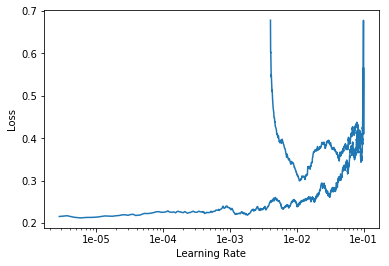

In [15]:
learn.recorder.plot()

In [16]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


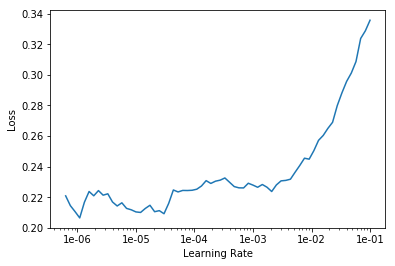

In [17]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3,slice(1e-5,5e-5))

epoch,train_loss,valid_loss,auc_score,time
0,0.218678,0.197133,0.973692,18:31


In [0]:
learn.recorder.plot()

In [0]:
learn.recorder.plot_losses()

In [0]:
preds,y=learn.get_preds()
pred_score=auc_score(preds,y)
pred_score

In [0]:
preds,y=learn.TTA()
pred_score_tta=auc_score(preds,y)
pred_score_tta

In [0]:
preds_test,y_test=learn.get_preds(ds_type=DatasetType.Test)

In [0]:
preds_test_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

In [0]:
sub=pd.read_csv(f'{path}/sample_submission.csv').set_index('id')
sub.head()
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned=clean_fname(data.test_ds.items)
fname_cleaned=fname_cleaned.astype(str)
sub.loc[fname_cleaned,'label']=to_np(preds_test[:,1])
sub.to_csv(f'submission_{pred_score}.csv')
sub.loc[fname_cleaned,'label']=to_np(preds_test_tta[:,1])
sub.to_csv(f'submission_{pred_score_tta}.csv')